* GradCAM
* See https://arxiv.org/abs/1610.02391

In [3]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from PIL import Image
from tqdm import tqdm

In [4]:
train, valid = chainer.datasets.get_cifar10(ndim=3, scale=255.)

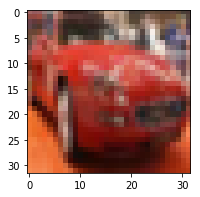

In [5]:
plt.figure(figsize=(3,3))
plt.imshow(Image.fromarray(train._datasets[0][5].transpose(1,2,0).astype(np.uint8)))
plt.show()

In [6]:
train_x, train_y = train._datasets
valid_x, valid_y = valid._datasets

train_x = np.array([L.model.vision.resnet.prepare(Image.fromarray(x.transpose(1,2,0).astype(np.uint8))) for x in tqdm(train_x, total=len(train_x))], dtype=np.float32)
train_y = train_y.astype(np.int32)
valid_x = np.array([L.model.vision.resnet.prepare(Image.fromarray(x.transpose(1,2,0).astype(np.uint8))) for x in tqdm(valid_x, total=len(valid_x))], dtype=np.float32)
valid_y = valid_y.astype(np.int32)

train_dataset = chainer.datasets.tuple_dataset.TupleDataset(train_x, train_y)
valid_dataset = chainer.datasets.tuple_dataset.TupleDataset(valid_x, valid_y)

len(train_dataset), len(valid_dataset)

100%|██████████| 10000/10000 [00:11<00:00, 858.51it/s]


(50000, 10000)

In [7]:
resnet = L.ResNet50Layers()
resnet.available_layers

['conv1', 'pool1', 'res2', 'res3', 'res4', 'res5', 'pool5', 'fc6', 'prob']

In [8]:
class ResNet50(chainer.Chain):
    
    def __init__(self, out_size):
        
        super(ResNet50, self).__init__(
            base = L.ResNet50Layers(),
            fc = L.Linear(None, out_size)
        )
        
    def __call__(self, x, gradcam=False):
        
        h = self.base(x, layers=['res5', 'pool5'])
        res5_h = h['res5']
        y = self.fc(h['pool5'])
        
        if gradcam:
            return {'res5': res5_h, 'fc': y}
        
        return y

In [9]:
gpu = 0

model = L.Classifier(ResNet50(out_size=10))
optimizer = chainer.optimizers.Adam(alpha=1e-4)
optimizer.setup(model)

for func_name in model.predictor.base._children:
    for param in model.predictor.base[func_name].params():
        param.update_rule.hyperparam.alpha *= 0.1

if gpu >= 0:
    chainer.cuda.get_device(gpu).use()
    model.to_gpu(gpu)

In [10]:
epoch_num = 10
batch_size = 128

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(valid_dataset, batch_size, repeat=False, shuffle=False)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu)
trainer = chainer.training.Trainer(updater, (epoch_num, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu))
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.695963    0.29468               0.779172       0.89913                   164.652       
2           0.196328    0.217175              0.936641       0.925534                  328.368       
3           0.089095    0.199657              0.97474        0.933544                  491.677       
4           0.0355803   0.213405              0.992927       0.93483                   655.386       
5           0.0145362   0.220086              0.998541       0.936313                  819.053       
6           0.00693191  0.231586              0.999519       0.936907                  982.326       
7           0.0041877   0.240006              0.99986        0.937203                  1145.96       
8           0.00280461  0.250985              0.99992        0.938192                  1309.21       
9           0.00204681  0.262931              0.99984        0.939082               

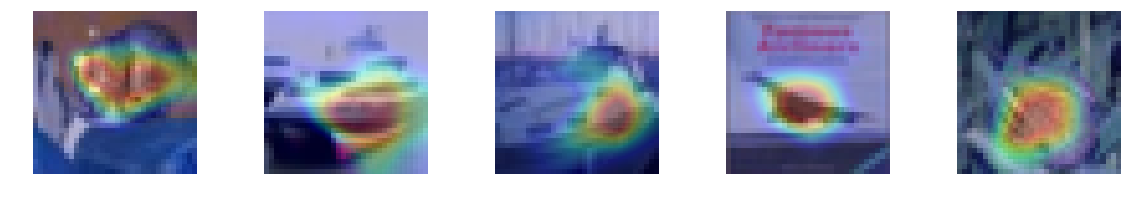

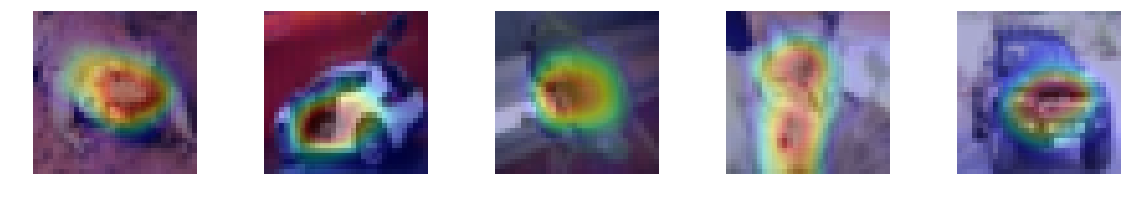

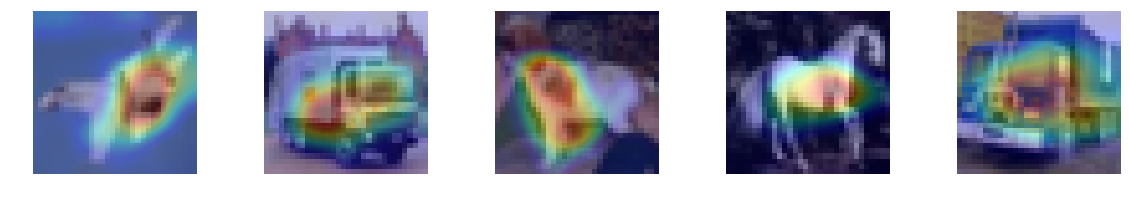

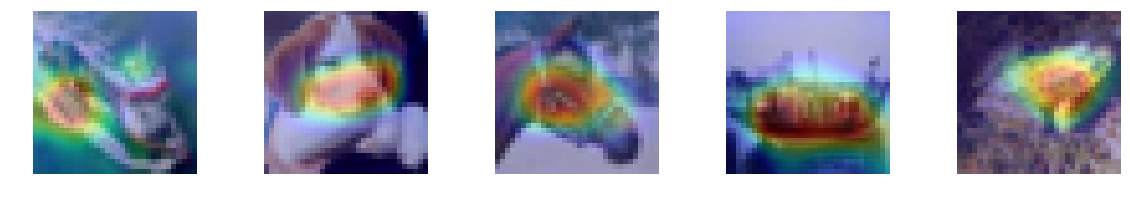

In [11]:
valid_x, valid_y = valid._datasets

for i, (x, y) in enumerate(zip(valid_x[:20], valid_y[:20])):
    
    if i%5 == 0:
        fig, axs = plt.subplots(ncols=5, figsize=(20,3))
        
    img = Image.fromarray(x.transpose(1,2,0).astype(np.uint8))
    x = L.model.vision.resnet.prepare(img)
    x = x[np.newaxis]
    x = chainer.cuda.to_gpu(x)

    with chainer.using_config('train', False):

        acts = model.predictor(x, gradcam=True)
        one_hot = model.xp.zeros((1, 10), dtype=np.float32)
        one_hot[:, y] = 1
        model.cleargrads()
        loss = F.sum(chainer.Variable(one_hot)*F.log_softmax(acts['fc']))
        loss.backward(retain_grad=True)

    cam = acts['res5']
    w = model.xp.mean(cam.grad, axis=(2, 3))
    gcam = model.xp.tensordot(w[0], cam.data[0], axes=(0, 0))
    gcam = chainer.cuda.to_cpu(gcam)
    gcam = (gcam > 0) * gcam / gcam.max() * 255
    gcam = Image.fromarray(gcam)
    gcam = gcam.resize(x.shape[2:4], 1)
    gcam = gcam.resize((224, 224))
    gcam = np.array(gcam)

    m = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(0, 1), cmap=matplotlib.cm.jet)
    overlay = Image.fromarray((m.to_rgba(gcam/255) * 255).astype(np.uint8))
    img = img.resize((224, 224)).convert('RGBA')
    blended = Image.blend(img, overlay, 0.3)
    
    axs[i%5].imshow(blended)
    axs[i%5].axis('off')
    
plt.show()

In [21]:
!python --version

Python 3.6.3


In [22]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
certifi==2018.4.16
chainer==4.0.0
chainercv==0.10.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
edward==1.3.5
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0.2.0
pexpect==4.5.0
pickleshare==0.7.4
Pillow==5.1.0
prompt-toolkit==1.0.15
protobuf==3.5.2.post1
ptyprocess==0.5.2
pycurl=

In [23]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [24]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
